In [2]:
%matplotlib inline
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns
from sklearn import linear_model, metrics, cross_validation
from sklearn import svm

/home/fatemeh/miniconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [81]:
t1 = pd.read_csv('~/others_projects/mina/sheet1.csv')

In [39]:
t1 = pd.read_csv('/home/fatemeh/others_projects/mina/Incidence.csv')
t1.drop(t1.columns[0], axis=1, inplace=True)
t1 = t1.rename(columns={'Presence of CAC': 'CAC', 'Hx of HTN': 'HTN'})
t1['Sex'] = t1['Sex'].str.strip()
t1['CAC'] = t1['CAC'].str.upper().str.strip()
t1['HTN'] = t1['HTN'].str.upper().str.strip()
t1['Side of CAC'] = t1['Side of CAC'].str.upper().str.strip()
t1['Age'] = t1['Age'].astype(int)

In [40]:
print(len(t1))
t1.columns

1000


Index(['Age', 'Sex', 'HTN', 'HTN Recoded', 'CAC', 'CAC Recoded', 'Side of CAC',
       'Anti-HTN Drug (Taking Presently or History of)'],
      dtype='object')

In [41]:
t1.describe()

,Age,HTN Recoded,CAC Recoded
count,1000.000000,999.000000,1000.000000
mean,64.694000,0.411411,0.280000
std,13.378915,0.492336,0.449224
min,30.000000,0.000000,0.000000
25%,57.000000,0.000000,0.000000
50%,66.000000,0.000000,0.000000
75%,74.000000,1.000000,1.000000
max,99.000000,1.000000,1.000000


In [43]:
cleaned = t1
cleaned.loc[cleaned['CAC'] == 'NO', 'cacv'] = -1
cleaned.loc[cleaned['CAC'] == 'YES', 'cacv'] = 1
cleaned.loc[cleaned['HTN'] == 'NO', 'htnv'] = -1
cleaned.loc[cleaned['HTN'] == 'YES', 'htnv'] = 1
cleaned.loc[cleaned.Sex == 'M', 'sexv'] = -1
cleaned.loc[cleaned.Sex == 'F', 'sexv'] = 1
cleaned['cacv']=cleaned.cacv.astype(int)
cleaned['sexv']=cleaned.sexv.astype(int)
cleaned['htnv']=cleaned.htnv.astype(int)

# Some Basic Stats

In [60]:
cleaned['count'] = 1
print('Average Age: {}\n'.format(cleaned['Age'].mean()))
print(cleaned[['CAC', 'count']].groupby('CAC').count().reset_index())
print('\n\n')
print(cleaned[['Sex', 'count']].groupby('Sex').count().reset_index())
print('\n\n')
print(cleaned[['HTN', 'count']].groupby('HTN').count().reset_index())
print('\n\nDistribution across different labels\n')

#sexDist['percentage'] = sexDist['count']
a = cleaned[['CAC', 'Sex', 'count']].groupby(['Sex', 'CAC']).count()
print(a.groupby(level=0).apply(lambda x:round(100 * x / float(x.sum()), 2)))
print('\n\n')
a = cleaned[['CAC', 'HTN', 'count']].groupby(['HTN', 'CAC']).count()
print(a.groupby(level=0).apply(lambda x:round(100 * x / float(x.sum()), 2)))
print('\n\n')
print(cleaned[['CAC', 'Age']].groupby(['CAC']).agg([np.mean, np.std]))
print('\n\n')
print(cleaned[['CAC', 'Sex', 'HTN', 'count']].groupby(['HTN', 'CAC', 'Sex']).count().reset_index())


Average Age: 64.694

   CAC  count
0   NO    720
1  YES    280



  Sex  count
0   F    499
1   M    501



   HTN  count
0   NO    574
1  YES    426


Distribution across different labels

         count
Sex CAC       
F   NO   75.95
    YES  24.05
M   NO   68.06
    YES  31.94



         count
HTN CAC       
NO  NO   87.63
    YES  12.37
YES NO   50.94
    YES  49.06



           Age           
          mean        std
CAC                      
NO   63.180556  13.839861
YES  68.585714  11.233581



   HTN  CAC Sex  count
0   NO   NO   F    282
1   NO   NO   M    221
2   NO  YES   F     31
3   NO  YES   M     40
4  YES   NO   F     97
5  YES   NO   M    120
6  YES  YES   F     89
7  YES  YES   M    120


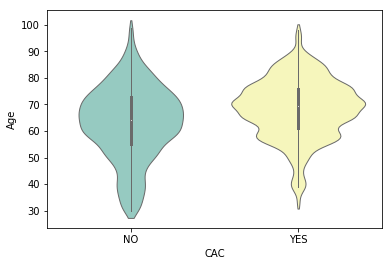

In [45]:
sns.violinplot(x='CAC', y='Age', data=cleaned, palette="Set3", bw=.2, cut=1, linewidth=1)

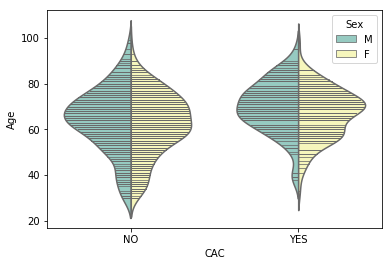

In [47]:
sns.violinplot(x="CAC", y="Age", hue="Sex", data=cleaned,
               split=True, inner="stick", palette="Set3");

[Text(0,0.5,'Sex Percentage')]

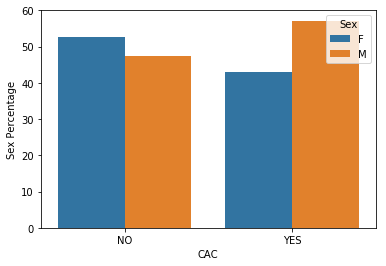

In [48]:
a = cleaned[['CAC', 'Sex', 'count']].groupby(['CAC', 'Sex']).count()
sexcac=a.groupby(level=0).apply(lambda x:round(100 * x / float(x.sum()), 2)).reset_index()
ax = sns.barplot(x="CAC", y="count", hue="Sex", data=sexcac)
#ax = sns.countplot(x="CAC", hue="Sex", data=cleaned)
ax.set(ylabel="Sex Percentage")

[Text(0,0.5,'Hx of HTN (%)')]

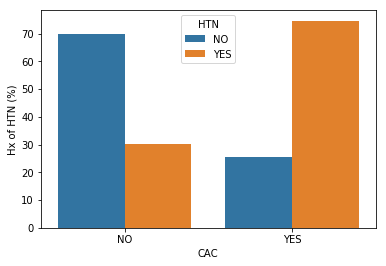

In [49]:
a = cleaned[['CAC', 'HTN', 'count']].groupby(['CAC', 'HTN']).count()
sexcac=a.groupby(level=0).apply(lambda x:round(100 * x / float(x.sum()), 2)).reset_index()
ax = sns.barplot(x="CAC", y="count", hue="HTN", data=sexcac)
ax.set(ylabel="Hx of HTN (%)")

In [51]:
res=pearsonr(cleaned['cacv'], cleaned['sexv'])
print('correlation: {}, p-value:{}'.format(res[0], res[1]))

correlation: -0.08784003718880022, p-value:0.005441816728264843


In [52]:
res=pearsonr(cleaned['cacv'], cleaned['htnv'])#.corr(method='pearson')
print('correlation: {}, p-value:{}'.format(res[0], res[1]))

correlation: 0.40409479387087605, p-value:1.438188890377796e-40


In [53]:
res=pearsonr(cleaned['cacv'], cleaned['Age'])#.corr(method='pearson')
print('correlation: {}, p-value:{}'.format(res[0], res[1]))

correlation: 0.1814889074082691, p-value:7.466915257195087e-09


In [54]:
logreg=linear_model.LogisticRegression(class_weight="balanced")
y = cleaned['CAC']
predicted = cross_validation.cross_val_predict(logreg, 
                                               cleaned[['htnv', 'sexv', 'Age']], 
                                               y , cv=10)
print(metrics.accuracy_score(y, predicted))
print(metrics.classification_report(y, predicted))

0.712
             precision    recall  f1-score   support

         NO       0.88      0.70      0.78       720
        YES       0.49      0.75      0.59       280

avg / total       0.77      0.71      0.73      1000



In [55]:
classifier=svm.SVC(kernel='rbf', class_weight="balanced")
y = cleaned['CAC']
predicted = cross_validation.cross_val_predict(classifier, 
                                               cleaned[['htnv', 'sexv', 'Age']], 
                                               y , cv=10)
print(metrics.accuracy_score(y, predicted))
print(metrics.classification_report(y, predicted))

0.651
             precision    recall  f1-score   support

         NO       0.83      0.64      0.73       720
        YES       0.42      0.67      0.52       280

avg / total       0.72      0.65      0.67      1000

